In [1]:
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from dataloader import *
from functools import reduce
from torch.autograd import Variable
from tqdm import tqdm
%matplotlib inline

In [2]:
class Model(nn.Module):
    def __init__(self,num_layers):
        super(Model,self).__init__()
        self.model1 = nn.ModuleList([nn.Sequential(nn.ConstantPad2d(1,0), nn.Conv2d(1,1,3,bias=False)) for i in range(num_layers)])
        self.model2 = nn.ModuleList([nn.Sequential(nn.ConstantPad2d(1,0), nn.Conv2d(1,1,3,bias=False)) for i in range(num_layers)])
        self.model3 = nn.ModuleList([nn.Sequential(nn.ConstantPad2d(1,0), nn.Conv2d(1,1,3,bias=False)) for i in range(num_layers)])
        self.model4 = nn.ModuleList([nn.Sequential(nn.ConstantPad2d(1,0), nn.Conv2d(1,1,3,bias=False)) for i in range(num_layers)])
#         self.model = nn.Sequential(self.model1)
    def forward(self,x):
#         print(x)
        x1 = reduce(lambda acc, el: el(acc), self.model1, x)
        x2 = reduce(lambda acc, el: el(acc), self.model2, x)
        x3 = reduce(lambda acc, el: el(acc), self.model3, x)
        x4 = reduce(lambda acc, el: el(acc), self.model4, x)
        
        x = torch.cat((x1,x2,x3,x4),1)
        return x

In [3]:
model = Model(3)
# delta X
nx = 128
delx = 2.*3.14/nx
delt = 0.2
epsilon = 0.50
d_ = torch.from_numpy(np.array([0.0/delx, 0.0/delx, -2./(delx**2), -2./(delx**2)])).type(torch.FloatTensor).cuda()
dx = torch.from_numpy(np.array([1.0/delx, 1.0/delx, 1.0/(delx**2), 1.0/(delx**2)])).type(torch.FloatTensor).cuda()

In [4]:
def psi_input(u1, u2, epsilon):
    filter_1 = -np.expand_dims(np.expand_dims(np.array([[0, 0, 0],[-0.5, 0, 0.5], [0, 0, 0]]), 0), 0)
    filter_2 = -np.expand_dims(np.expand_dims(np.array([[0, -0.5, 0],[0, 0, 0],[0, 0.5, 0]]), 0), 0) 
    filter_3 = np.expand_dims(np.expand_dims(np.array([[0, 0, 0],[1., 0, 1.],[0, 0, 0]]), 0), 0) #d_2 = -2.
    filter_4 = np.expand_dims(np.expand_dims(np.array([[0, 1., 0],[0, 0, 0],[0, 1., 0]]), 0), 0) #d_2 = -2.
    filter_5 = np.expand_dims(np.expand_dims(np.array([[0, 0, 0],[1., -2., 1.],[0, 0, 0]]), 0), 0) #d_2 = -2.
    filter_6 = np.expand_dims(np.expand_dims(np.array([[0, 1., 0],[0, -2., 0],[0, 1., 0]]), 0), 0) #d_2 = -2.
    Filter_var_d = np.concatenate([filter_1, filter_2, filter_3, filter_4],axis=0)
    Filter_var = np.concatenate([filter_1, filter_2, filter_5, filter_6],axis=0)
    if(torch.cuda.is_available()!=False):
        Filter_var = Variable(torch.FloatTensor(Filter_var).cuda(), requires_grad=False)
        Filter_var_d = Variable(torch.FloatTensor(Filter_var_d).cuda(), requires_grad=False)
    else:
        Filter_var = Variable(torch.FloatTensor(Filter_var), requires_grad=False)
        Filter_var_d = Variable(torch.FloatTensor(Filter_var_d), requires_grad=False)
    u1 = F.pad(u1, (1,1,1,1), mode='constant')
    u2 = F.pad(u2, (1,1,1,1), mode='constant')
    out1 = F.conv2d(u1, Filter_var_d, stride=1, padding=0)
    out2 = F.conv2d(u2, Filter_var, stride=1, padding=0)
    return out1*epsilon+(1-epsilon)*out2

In [5]:
def getG(psi):
    psi.data[:,:,0,:] = 1e-10
    psi.data[:,:,:,0] = 1e-10
    psi.data[:,:,-1,:] = 1e-10
    psi.data[:,:,:,-1] = 1e-10
    return psi

In [6]:
def parameter_mult(psi, parameters):
    out = torch.mul(psi, parameters.unsqueeze(-1).unsqueeze(-1))
    output = torch.sum(out, 1, keepdim=True)
    return output

In [7]:
def phi_input(phi, u, parameter, delta_t, epsilon):
    
    div = 1.0/(1.0 - torch.sum(delt*epsilon*torch.mul(parameter, d_), 1)).unsqueeze(1)
    parameter = torch.mul(parameter, dx)
    lamda = torch.mul(parameter, div)

    psi = phi

    psi = parameter_mult(psi_input(psi, u, epsilon), lamda)*delta_t+parameter_mult(u, div)
    psi = getG(psi)
    w = psi - phi
    # Boundary correction should be here on psi
    #     print(model(input_to_net).shape)

    w = getG(parameter_mult(model(w),  lamda*delta_t*epsilon))
        
    phi = w + psi
#         psi = phi
    return phi

In [8]:
def neural_solver(u, parameter, delta_t, epsilon):
    phi = u
#     iter_ = np.random.randint(1, 20)
    iter_= 10
    for _ in range(iter_):
        phi = phi_input(phi, u, parameter, delta_t, epsilon)
    return phi

In [9]:
def implicit_FDM(u, parameter, delta_t, epsilon):
    div = 1.0/(1.0 - torch.sum(delt*epsilon*torch.mul(parameter, d_), 1)).unsqueeze(1)
    parameter = torch.mul(parameter, dx)
    lamda = torch.mul(parameter, div)
    psi = u
    for i in range(25):
        psi = parameter_mult(psi_input(psi, u, epsilon), lamda)*delta_t+parameter_mult(u, div)
        psi = getG(psi)
        # Boundary correction should be here on psi
    #     print(model(input_to_net).shape)

    return psi

In [10]:
model = torch.load('./Model/model_0.5_final.pt')
model.cuda()

Model(
  (model1): ModuleList(
    (0): Sequential(
      (0): ConstantPad2d(padding=(1, 1, 1, 1), value=0)
      (1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    )
    (1): Sequential(
      (0): ConstantPad2d(padding=(1, 1, 1, 1), value=0)
      (1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    )
    (2): Sequential(
      (0): ConstantPad2d(padding=(1, 1, 1, 1), value=0)
      (1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    )
  )
  (model2): ModuleList(
    (0): Sequential(
      (0): ConstantPad2d(padding=(1, 1, 1, 1), value=0)
      (1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    )
    (1): Sequential(
      (0): ConstantPad2d(padding=(1, 1, 1, 1), value=0)
      (1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    )
    (2): Sequential(
      (0): ConstantPad2d(padding=(1, 1, 1, 1), value=0)
      (1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    )
  )
  (model3): M

In [11]:
sum(p.numel() for p in model.parameters())

108

In [12]:
def parameter(filename):
    data = pd.read_csv(filename,header=None)
    output = np.array(data)
    output = torch.tensor(output)
    return output

In [13]:
def error_plot(data_list, parafile):
    param = parameter(parafile).type(torch.FloatTensor).cuda().squeeze().unsqueeze(0)
    print(param)
    fdm = []
    network = []
    model.eval()
    n = 10
    lebel = ["FEniCS","Neural", "Semi-implicit"]
    fig, ax = plt.subplots(3, n, figsize=(30,9), gridspec_kw = {'wspace':0.02, 'hspace':0.02})
    for idx in range(1,n+1):

        ground_truth = np.expand_dims(np.expand_dims(parameter(data_list[idx+1]),axis=0),axis=0)

#         print(ground_truth.shape)
        if idx == 1:
            data = np.expand_dims(np.expand_dims(parameter(data_list[idx]),axis=0),axis=0)
            data = torch.tensor(data)
            data = data.type(torch.FloatTensor).cuda()
            input1 = data
            input2 = data
            
        output2 = neural_solver(input2, param, delt, epsilon)
        errorNetwork = np.square(ground_truth - output2.cpu().detach().numpy()).mean()

        output1 = implicit_FDM(input1, param, delt, epsilon)
        errorFDM = np.square(ground_truth - output1.cpu().detach().numpy()).mean()
        fdm.append(errorFDM)
        
        
#         print('output shape', output1.shape, output2.shape, ground_truth.shape)
        network.append(errorNetwork)
        input1 = output1
        input2 = output2
        
        output1 = output1.cpu().detach().numpy()
        output2 = output2.cpu().detach().numpy()
        
        target_image = ground_truth.squeeze(0).squeeze(0)
        output_image = output2.squeeze(0).squeeze(0)
        FDM_out = output1.squeeze(0).squeeze(0)

        
#         plt.subplot(1,3,1)
#         plt.title('Input image')
#         plt.axis('off')
#         plt.imshow(input_image)
#         cbar = plt.colorbar()
#         cbar.ax.tick_params(labelsize=20) 
#         plt.subplot(3,n,idx+1)
#         plt.title('Target image')
        
        ax[0, idx-1].imshow(target_image)
#         cbar = ax[0, idx].colorbar()
#         cbar.ax.tick_params(labelsize=20) 
#         plt.subplot(3,n,n+idx+1)
#         plt.title('Output image')
#         ax[0, idx-1].axis('off')
        ax[1, idx-1].imshow(output_image)
#         cbar = ax[1, idx].colorbar()
#         cbar.ax.tick_params(labelsize=20) 
#         plt.subplot(3,n,2*n+idx+1)
#         plt.title('FDM Output')
#         ax[1, idx-1].axis('off')
        ax[2, idx-1].imshow(FDM_out)
#         cbar = ax[2, idx].colorbar()
#         cbar.ax.tick_params(labelsize=20) 
#         ax[2, idx-1].axis('off')
    
    for i in range(n):
        ax[2,i].set_xlabel("t = %.2f"%(i*0.2+0.2), fontsize=36)
    for j in range(3):
        ax[j,0].set_ylabel(lebel[j], fontsize=36)
    for i in range(n):
        for j in range(3):
            ax[j, i].set_xticks([])
            ax[j, i].set_yticks([])
    plt.show()
#         print('Neural Error', ((output_image - target_image)**2).mean(), 'FDM Error', ((FDM_out - target_image)**2).mean())
        
#     x_axis = range(n)
#     y_axis1 = fdm
#     y_axis2 = network
#     plt.plot(x_axis,y_axis1,label='fdm')
#     plt.plot(x_axis,y_axis2,label = 'Network')
#     plt.legend()
#     plt.show()
    return fdm, network

## delx = 128

In [14]:
list_of_parameters_5 = glob.glob('./data/128/*.csv',recursive=True)

In [15]:
test_data_5 = []
for i in list_of_parameters_5:
    test_data_5.append(os.path.split(i)[1][:-15])

tensor([[0.0162, 1.3779, 0.3519, 0.5808]], device='cuda:0')


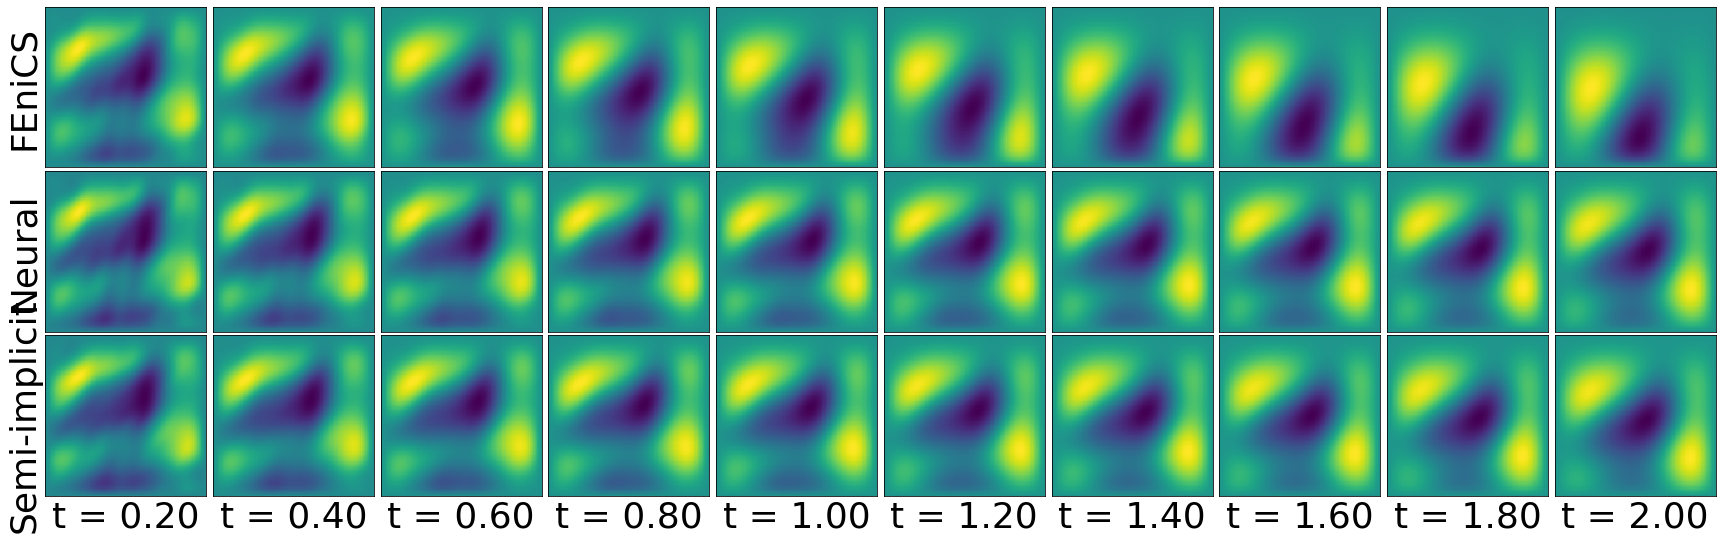

In [16]:
implicit_5 = []
neural_5 = []
m = 5
for number in test_data_5[m:m+1]:
    data_list = glob.glob('./data/128/'+number+'/*.csv')
    data_list = sorted(data_list, key=lambda a: int(os.path.split(a)[1][:-4].zfill(3)))
    parafile = './data/128/'+number+'_parameters.csv'
    error1, error2 = error_plot(data_list, parafile)
    implicit_5.append(error1)
    neural_5.append(error2)

In [17]:
implicit_5 = np.array(implicit_5)
neural_5 = np.array(neural_5)

In [18]:
implicit_mean_5, implicit_sd_5 = np.mean(implicit_5, 0), np.std(implicit_5, 0)
neural_mean_5, neural_sd_5 = np.mean(neural_5, 0), np.std(neural_5, 0)

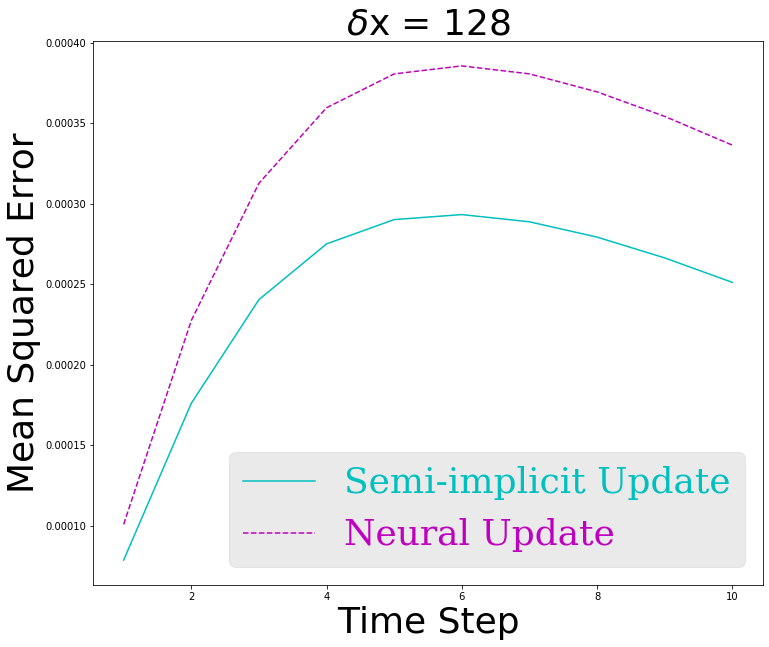

In [19]:
t = np.linspace(1,10,10)
plt.figure(figsize=(12,10))
plt.title('$\delta$x = 128',fontsize=36)
# plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.style.use('ggplot')
plt.plot(t, implicit_mean_5, 'c-', label='Semi-implicit Update')
plt.plot(t, neural_mean_5, 'm--', label='Neural Update')
plt.fill(np.concatenate([t, t[::-1]]),
         np.concatenate([implicit_mean_5 - 0.19600 * implicit_sd_5,
                        (implicit_mean_5 + 0.19600 * implicit_sd_5)[::-1]]),
         alpha=.5, fc='aqua', ec='None')

plt.fill(np.concatenate([t, t[::-1]]),
         np.concatenate([neural_mean_5 - 0.19600 * neural_sd_5,
                        (neural_mean_5 + 0.19600 * neural_sd_5)[::-1]]),
         alpha=.5, fc='orange', ec='None')

plt.xlabel('Time Step', fontsize=36)
plt.ylabel('Mean Squared Error', fontsize=36)
plt.legend()
matplotlib.rc('xtick', labelsize=36) 
matplotlib.rc('ytick', labelsize=36)
l = plt.legend(prop={'size': 36})
leg_texts = l.get_texts() # list of matplotlib Text instances.
leg_texts[0].set_color("c")
leg_texts[1].set_color("m")
plt.show()

## delx = 192

In [20]:
nx = 192
delx = 2.*3.14/nx
delt = 0.2
epsilon = 0.50
d_ = torch.from_numpy(np.array([0.0/delx, 0.0/delx, -2./(delx**2), -2./(delx**2)])).type(torch.FloatTensor).cuda()
dx = torch.from_numpy(np.array([1.0/delx, 1.0/delx, 1.0/(delx**2), 1.0/(delx**2)])).type(torch.FloatTensor).cuda()

In [21]:
list_of_parameters_6 = glob.glob('./data/192/*.csv',recursive=True)

In [22]:
test_data_6 = []
for i in list_of_parameters_6:
    test_data_6.append(os.path.split(i)[1][:-15])

tensor([[0.6625, 0.3867, 0.2377, 0.7882]], device='cuda:0')


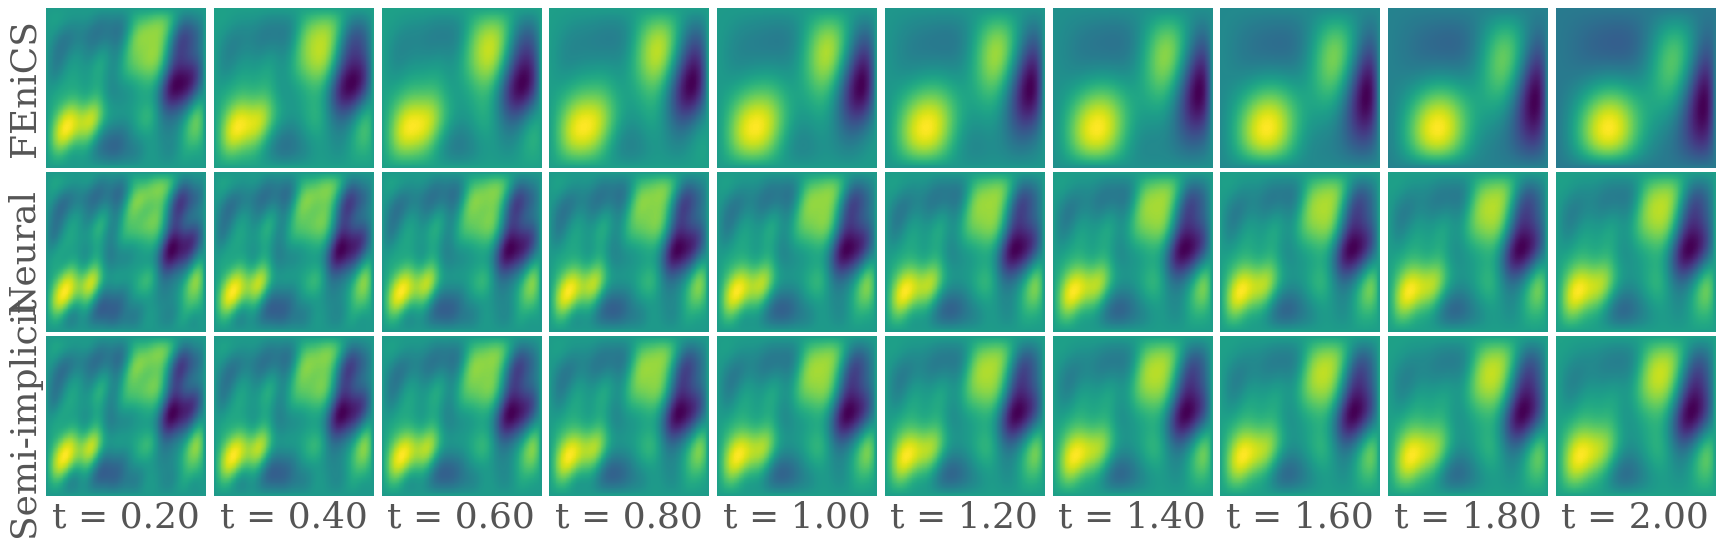

In [23]:
implicit_6 = []
neural_6 = []
m = 1
for number in test_data_6[m:m+1]:
    data_list = glob.glob('./data/192/'+number+'/*.csv')
    data_list = sorted(data_list, key=lambda a: int(os.path.split(a)[1][:-4].zfill(3)))
    parafile = './data/192/'+number+'_parameters.csv'
    error1, error2 = error_plot(data_list, parafile)
    implicit_6.append(error1)
    neural_6.append(error2)

In [24]:
implicit_6 = np.array(implicit_6)
neural_6 = np.array(neural_6)

In [25]:
implicit_mean_6, implicit_sd_6 = np.mean(implicit_6, 0), np.std(implicit_6, 0)
neural_mean_6, neural_sd_6 = np.mean(neural_6, 0), np.std(neural_6, 0)

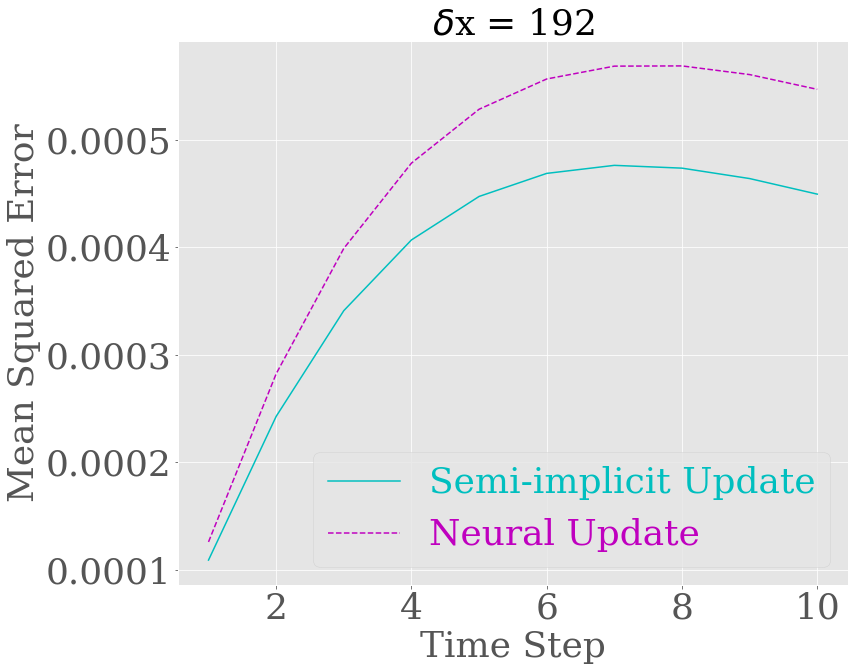

In [26]:
t = np.linspace(1,10,10)
plt.figure(figsize=(12,10))
plt.title('$\delta$x = 192',fontsize=36)
# plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.style.use('ggplot')
plt.plot(t, implicit_mean_6, 'c-', label='Semi-implicit Update')
plt.plot(t, neural_mean_6, 'm--', label='Neural Update')
plt.fill(np.concatenate([t, t[::-1]]),
         np.concatenate([implicit_mean_6 - 0.19600 * implicit_sd_6,
                        (implicit_mean_6 + 0.19600 * implicit_sd_6)[::-1]]),
         alpha=.5, fc='aqua', ec='None')

plt.fill(np.concatenate([t, t[::-1]]),
         np.concatenate([neural_mean_6 - 0.19600 * neural_sd_6,
                        (neural_mean_6 + 0.19600 * neural_sd_6)[::-1]]),
         alpha=.5, fc='orange', ec='None')

plt.xlabel('Time Step', fontsize=36)
plt.ylabel('Mean Squared Error', fontsize=36)
plt.legend()
matplotlib.rc('xtick', labelsize=36) 
matplotlib.rc('ytick', labelsize=36)
l = plt.legend(prop={'size': 36})
leg_texts = l.get_texts() # list of matplotlib Text instances.
leg_texts[0].set_color("c")
leg_texts[1].set_color("m")
plt.show()